In [1]:
import keras.backend as K
import sys
sys.path.append('/home/albert/github/tensorflow/src/')
import evaluation
import data
import dense
import triplet

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.losses import categorical_hinge
from keras.optimizers import Adam
from keras.models import Model

In [3]:
model = evaluation.load_model('/home/albert/github/tensorflow/pre/pre3/models/densenet_triplet/densenet_triplet.json', 
                              '/home/albert/github/tensorflow/pre/pre3/models/neck_cam_inverse_aws/neck_cam_inverse_aws_10000.npy')

In [4]:
model.layers[310].get_config()

{'data_format': u'channels_last',
 'name': u'average_pooling2d_3',
 'padding': u'valid',
 'pool_size': (2, 2),
 'strides': (2, 2),
 'trainable': True}

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [6]:
for l in range(len(model.layers)):
    if model.layers[l].name.find('pool') > -1:
        print l

4
50
138
310
425


In [12]:
pool_model = Model(inputs=model.input, outputs=model.layers[-6].output)
pool_model.compile(loss=categorical_hinge, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [13]:
train_dict, train_files = data.get_data('train')

preprocess False
keypoints None


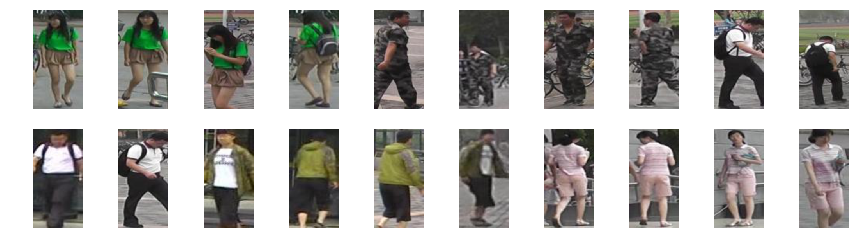

In [14]:
batch = data.output_batch_generator(train_dict, P=5, preprocess=False, shape=(256,128), keypoints=None).next()
plt.figure(figsize=(15,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

In [50]:
pool = pool_model.predict(batch[0]['input_im'].reshape((-1,256,128,3)))

0.0 214.436


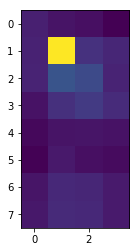

In [51]:
plt.imshow(np.mean(pool[0], axis=2))
print pool.min(), pool.max()

In [52]:
def L(a,b, e=2):
    return np.exp(-(a**2 + b**2)/(2*e**2))

In [53]:
def norm(x1, x2, axis=1, norm=1):
    return np.power(np.sum(np.power(np.abs(x1 - x2), norm), axis=axis), 1.0 / norm)

In [56]:
start = time.time()

height = pool.shape[1]
width = pool.shape[2]

norms = norm(pool.reshape((-1, height * width, 1, pool.shape[3])), 
             np.tile(pool.reshape((-1, 1, height * width, pool.shape[3])), [1, height * width, 1, 1]), axis=3)

L_x = np.tile(np.arange(0, width, 1, float), height).reshape((1, height*width))
L_x_0 = np.tile(L_x.reshape((1, height * width, 1)), [pool.shape[0],1,1])
L_x_1 = np.tile(L_x, [pool.shape[0],height * width, 1])

L_y = np.arange(0, height, 1, float).repeat(width).reshape((1, height*width))
L_y_0 = L_y.reshape((height * width, 1))
L_y_1 = np.tile(L_y, [pool.shape[0],height * width, 1])

L_maps = L(L_x_0 - L_x_1, L_y_0-L_y_1)

D = np.multiply(norms, L_maps)
D = np.divide(D, np.tile(np.sum(D, axis=2).reshape((-1, height * width, 1)), [1,1, height * width]))
        
print time.time() - start

0.292953968048


In [57]:
norms.shape

(20, 32, 32)

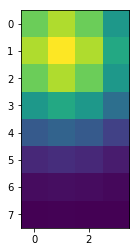

In [58]:
plt.imshow(L_maps[0][5].reshape((8,4)))

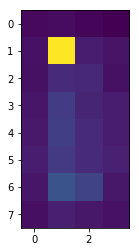

In [65]:
D_0 = np.matrix(D[6])
D_0 = np.matrix.transpose(D_0)
M = np.matrix(np.ones((height * width,), dtype=np.float64) / D_0.shape[0])

M = M * np.matrix.transpose(D_0)
plt.imshow(M.reshape((height,width)))

In [82]:
np.array(M)

array([[ 0.01729403,  0.01956016,  0.01882396,  0.01681198,  0.02160576,
         0.09245495,  0.03006981,  0.02018035,  0.02471793,  0.0387378 ,
         0.03870126,  0.02392848,  0.02764498,  0.03990806,  0.0311593 ,
         0.02504274,  0.02938792,  0.03880078,  0.03468334,  0.03146786,
         0.02844562,  0.04243445,  0.03675467,  0.03313265,  0.02563108,
         0.04212564,  0.04390257,  0.02623272,  0.02274263,  0.02883953,
         0.02778902,  0.02098795]])

In [83]:
np.sum(M)

1.0

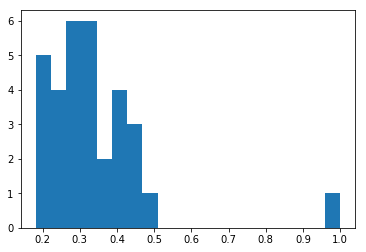

In [84]:
plt.hist(np.array(M / M.max()).tolist(), bins=20)
plt.show()

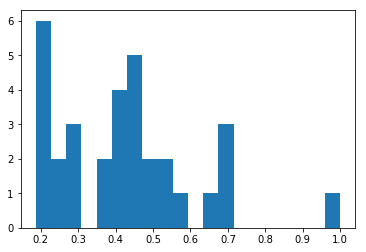

In [85]:
plt.hist((np.mean(pool, axis=2).flatten() / np.mean(pool, axis=2).max()).tolist(), bins=20)
plt.show()

In [109]:
start = time.time()

height = pool.shape[1]
width = pool.shape[2]

D = np.zeros((height * width,) * 2, dtype=np.float64)
# for i in range(height):
#     for j in range(width):
#         s = 0
#         for p in range(height):
#             for q in range(width):
#                 D[width*i+j, width*p+q] = norm(pool[i,j], pool[p,q], axis=0) * L(i-p, j-q)
#                 s += D[width*i+j, width*p+q]
#         D[width*i+j] /= s

# for i in range(height):
#     for j in range(width):
#         L_map = L(j-np.arange(0, width, 1, float), i-np.arange(0, height, 1, float)[:, np.newaxis])
#         weights = np.multiply(norm(pool[i,j], pool.reshape((height*width, pool.shape[2])), axis=1), L_map.flatten())
#         D[width*i+j] = weights / weights.sum()


for i in range(height):
    for j in range(width):
        L_map = L(j-np.arange(0, width, 1, float), i-np.arange(0, height, 1, float)[:, np.newaxis])
        weights = np.multiply(norm(pool[i,j], pool.reshape((height*width, pool.shape[2])), axis=1), L_map.flatten())
        D[width*i+j] = weights / weights.sum()
    
print time.time() - start

0.011862039566


In [110]:
D = np.matrix(D)
D = np.matrix.transpose(D)
M = np.matrix(np.ones((height * width,), dtype=np.float64) / D.shape[0])

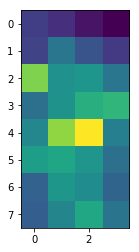

In [114]:
M = M * np.matrix.transpose(D)
plt.imshow(M.reshape((height,width)))